In [1]:
import os
import warnings
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
import joblib
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [2]:
# Load the transactional dataset that was created by the team
df_transactions = pd.read_csv("../dataset/project-dataset/transactions.csv")

In [ ]:
# Clean amount column
df_transactions['amount_cleaned'] = df_transactions['amount'].apply(lambda x: float(x.replace('$', '')) if isinstance(x, str) else float(x))

In [ ]:

df_transactions['date'] = pd.to_datetime(df_transactions['date'])


snapshot_date = df_transactions['date'].max()

#RFM
df_rfm = df_transactions.groupby('customer_id').agg({
    'date': lambda x: (snapshot_date - x.max()).days,   # Recency
    'customer_id': 'count',                  # Frequency
    'amount_cleaned': 'sum'                  # Monetary
}).rename(columns={
    'date': 'recency',
    'customer_id': 'frequency',
    'amount_cleaned': 'monetary'
}).reset_index()


# Credit_card Model (Cluster model)

In [ ]:
# K-means model
cluster_features = df_rfm[['recency', 'frequency', 'monetary']].fillna(0)
kmeans = KMeans(n_clusters=5, random_state=42).fit(cluster_features)

df_rfm['cluster'] = kmeans.labels_


In [ ]:
# K-means summary
cluster_summary = df_rfm.groupby('cluster').agg({
    'frequency': 'mean',
    'monetary': 'mean',
    'recency': 'mean',
    'customer_id': 'count'
}).rename(columns={'customer_id': 'num_customers'})


cluster_summary = cluster_summary[['num_customers', 'frequency', 'monetary', 'recency']]


print(cluster_summary)


         num_customers  frequency     monetary     recency
cluster                                                   
0               248694  10.771707   383.116253  101.598981
1               234844  15.766960   907.989794   66.833409
2               330725  13.760937   638.729808   74.427413
3               102885  17.192273  1266.129275   62.383146
4                22321  17.605573  1913.712897   61.534474


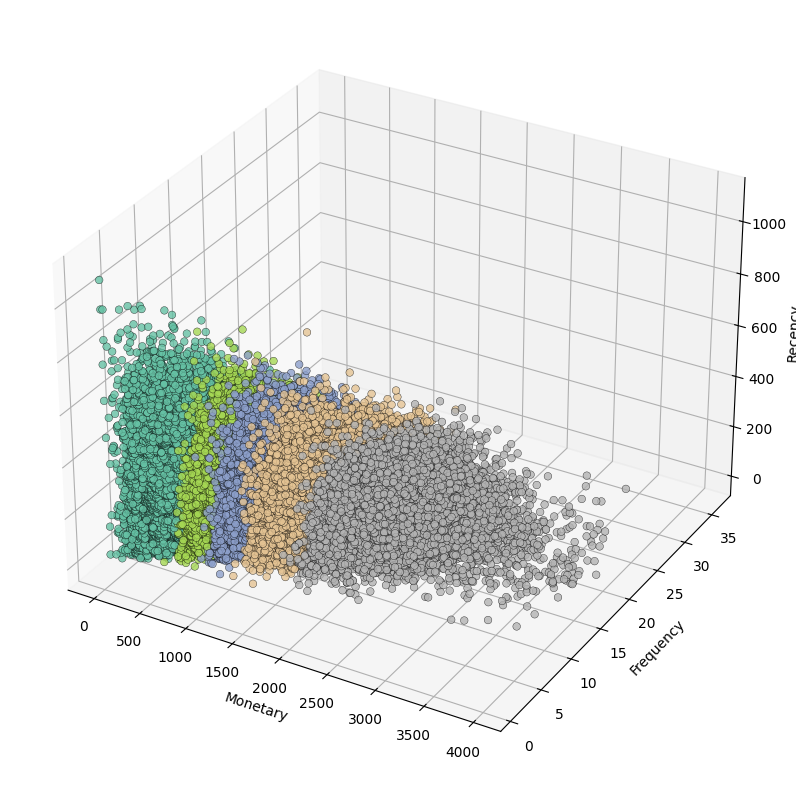

In [ ]:
# draw 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


df_plot = df_rfm[df_rfm['monetary'] <= 4000]


ax.scatter(
    df_plot['monetary'],
    df_plot['frequency'],
    df_plot['recency'],
    c=df_plot['cluster'],
    cmap='Set2',
    s=30,
    alpha=0.8,
    edgecolors='k',
    linewidth=0.3
)


ax.set_xlabel('Monetary')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

plt.tight_layout()
plt.show()


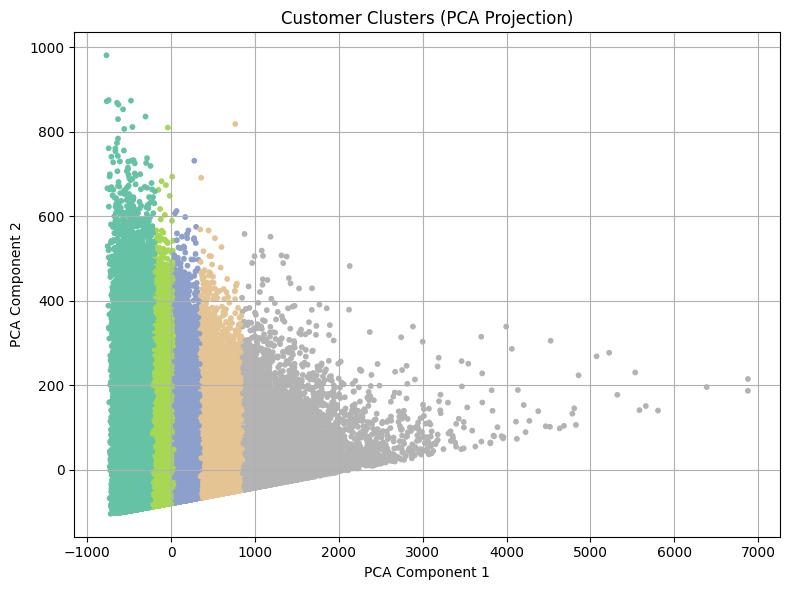

In [ ]:
# PCA Projection

rfm_scaled = cluster_features.copy()
pca = PCA(n_components=2)
components = pca.fit_transform(rfm_scaled)
df_rfm['pca1'] = components[:, 0]
df_rfm['pca2'] = components[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(df_rfm['pca1'], df_rfm['pca2'], c=df_rfm['cluster'], cmap='Set2', s=10)
plt.title('Customer Clusters (PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
df_rfm['cluster'] = kmeans.labels_

Next Step use the df_rfm merge with transacation data, then you can define the credit_card features by the new df_transaction

In [ ]:
# Add decision and Classification
df_rfm['recommend_credit_card'] = 0


df_rfm.loc[
    (df_rfm['cluster'].isin([3, 4])) |
    (
        df_rfm['cluster'].isin([1, 2]) &
        (
            (df_rfm['frequency'] >= 16) |
            (df_rfm['monetary'] >= 1000)
        )
    ),
    'recommend_credit_card'
] = 1


In [ ]:
df_rfm

,customer_id,recency,frequency,monetary,cluster,pca1,pca2,recommend_credit_card
0,15889,1,15,573.00,2,-161.418936,-83.102318,0
1,15890,128,9,459.21,0,-279.836247,39.668684,0
2,15891,242,14,491.36,0,-251.868693,154.728301,0
3,15892,50,21,1219.87,3,483.237068,-10.372569,1
4,15893,14,13,617.59,2,-117.350324,-68.452881,0
...,...,...,...,...,...,...,...,...
939464,1553685,34,16,829.69,1,93.885542,-40.683827,1
939465,1553686,3,13,417.85,0,-316.547011,-86.798876,0
939466,1553687,17,11,486.92,0,-248.052188,-70.248870,0
939467,1553688,130,12,440.78,0,-298.308303,40.963144,0


In [ ]:
df_rfm.to_csv("transaction_data_recommendations.csv", index=False)


# Recommendation strategy description:
# - Clusters 3 and 4: High-frequency, high-spending groups; strongly recommend credit cards
# - In clusters 1 and 2, frequency ≥ 16 or monetary ≥ 1000: Moderate to high spending power; recommend credit cards
#Use all new columns recommend_credit_card with a value of 1 for customers

# Recommend Direct_debit (RFM score model)

In [ ]:
df_rfm['R_score'] = pd.qcut(df_rfm['recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
df_rfm['F_score'] = pd.qcut(df_rfm['frequency'], 5, labels=[1, 2, 3, 4, 5]).astype(int)
df_rfm['M_score'] = pd.qcut(df_rfm['monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)


df_rfm['RFM_score'] = df_rfm[['R_score', 'F_score', 'M_score']].sum(axis=1)


def map_recommend(score):
    if score >= 12:
        return 'Strong Recommend'
    elif score >= 9:
        return 'Recommend'
    elif score >= 6:
        return 'Consider'
    else:
        return 'Not Recommend'

df_rfm['direct_debit_recommendation'] = df_rfm['RFM_score'].apply(map_recommend)


recommend_summary = df_rfm['direct_debit_recommendation'].value_counts().sort_index()
print(" Direct Debit RFM Recommendation Summary:\n")
print(recommend_summary)

📊 Direct Debit RFM Recommendation Summary:

direct_debit_recommendation
Consider            280256
Not Recommend       163490
Recommend           287812
Strong Recommend    207911
Name: count, dtype: int64


In [ ]:
#report
recommend_stats = df_rfm.groupby('direct_debit_recommendation').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'RFM_score': 'mean',
    'customer_id': 'count'
}).rename(columns={'customer_id': 'num_customers'})
recommend_stats

,recency,frequency,monetary,RFM_score,num_customers
direct_debit_recommendation,,,,,
Consider,84.907349,12.135547,589.120440,7.058818,280256
Not Recommend,162.708881,9.808416,408.412274,4.142204,163490
Recommend,59.549810,14.955829,819.964173,9.971881,287812
Strong Recommend,28.055610,18.206911,1081.563223,13.047698,207911


from matplotlib import pyplot as plt
recommend_stats['recency'].plot(kind='hist', bins=20, title='recency')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
recommend_stats['frequency'].plot(kind='hist', bins=20, title='frequency')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
recommend_stats['monetary'].plot(kind='hist', bins=20, title='monetary')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
recommend_stats['RFM_score'].plot(kind='hist', bins=20, title='RFM_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
recommend_stats.plot(kind='scatter', x='recency', y='frequency', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
recommend_stats.plot(kind='scatter', x='frequency', y='monetary', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
recommend_stats.plot(kind='scatter', x='monetary', y='RFM_score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
recommend_stats.plot(kind='scatter', x='RFM_score', y='num_customers', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
recommend_stats['recency'].plot(kind='line', figsize=(8, 4), title='recency')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
recommend_stats['frequency'].plot(kind='line', figsize=(8, 4), title='frequency')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
recommend_stats['monetary'].plot(kind='line', figsize=(8, 4), title='monetary')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
recommend_stats['RFM_score'].plot(kind='line', figsize=(8, 4), title='RFM_score')
plt.gca().spines[['top', 'right']].set_visible(False)